# Week 17, Lecture 02: CodeAlong


## **Part 2: Explaining Models with Model Explainers**

### Lesson Objectives

- By the end of this lesson, students will be able to:
    - Load variables and models from a joblib file into a new notebook.
    - Apply permutation importance
    - Apply shap analysis 
    - Visualize global and local explanations.


### Continuing with Life Expectancy Prediction

> Task Inspired by: https://medium.com/@shanzehhaji/using-a-linear-regression-model-to-predict-life-expectancy-de3aef66ac21

- Kaggle Dataset on Life Expectancy:
    - https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

In [55]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [56]:
## Importing Custom Functions
import sys,os
# sys.path.append(os.path.abspath("../"))
%load_ext autoreload
%autoreload 2
from CODE import data_enrichment as de

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functionized Code From Part 1

In [57]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

##  🕹️ Loading Objects from a Joblib

In [58]:
## Load the joblib file stored in the models folder
fname = "Models/wk1-lect01-codealong.joblib"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [59]:
## Saving the loaded objects as separate varaibles

## Saving the loaded objects as separate varaibles

X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

X_train.head()

,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2414,2010,Developing,359.0,27,NaN,0.000000,NaN,0,NaN,41,NaN,NaN,NaN,4.0,1562.239346,167192.0,NaN,NaN,0.000,0.0
1576,2009,Developing,491.0,36,1.16,7.915071,93.0,21,17.3,56,93.0,1.18,93.0,14.9,42.737966,1471462.0,6.9,6.8,0.415,9.9
2559,2009,Developing,174.0,10,0.30,35.716138,93.0,0,35.9,12,93.0,5.93,93.0,0.2,666.345857,7472819.0,3.7,3.8,0.601,11.1
1524,2013,Developed,178.0,0,15.04,1968.816817,93.0,35,61.4,0,93.0,6.59,93.0,0.1,15712.823760,2957689.0,2.7,2.7,0.834,16.4
33,2014,Developing,11.0,21,0.01,54.237318,95.0,0,58.4,24,95.0,7.21,95.0,0.1,547.851700,39113313.0,6.0,5.8,0.741,14.4


> Let's evaluate our models to prove they saved correctly.

In [60]:
## Use our evaluate_regression function to evalaute the linear regression

evaluate_regression(lin_reg_final,X_train,y_train, X_test, y_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Status
Feature names seen at fit time, yet now missing:
- Status_Developing


> ***Q: What is my error?***

### Re-Creating X_train_df & X_test_df

In [61]:
## Get feature names from already-fit preprocessor

feature_names = preprocessor.get_feature_names_out()

## Use the preprocessor to transform X_train into X_train_df
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)


## Use the preprocessor to transform X_test into X_test_df 

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                         columns=feature_names)
X_train_df.head()


,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
2414,2010.0,359.0,27.0,4.580078,0.000000,81.438929,0.0,38.113041,41.0,82.490834,5.931982,82.451879,4.0,1562.239346,167192.0,4.811567,4.819493,0.000,0.0,1.0
1576,2009.0,491.0,36.0,1.160000,7.915071,93.000000,21.0,17.300000,56.0,93.000000,1.180000,93.000000,14.9,42.737966,1471462.0,6.900000,6.800000,0.415,9.9,1.0
2559,2009.0,174.0,10.0,0.300000,35.716138,93.000000,0.0,35.900000,12.0,93.000000,5.930000,93.000000,0.2,666.345857,7472819.0,3.700000,3.800000,0.601,11.1,1.0
1524,2013.0,178.0,0.0,15.040000,1968.816817,93.000000,35.0,61.400000,0.0,93.000000,6.590000,93.000000,0.1,15712.823760,2957689.0,2.700000,2.700000,0.834,16.4,0.0
33,2014.0,11.0,21.0,0.010000,54.237318,95.000000,0.0,58.400000,24.0,95.000000,7.210000,95.000000,0.1,547.851700,39113313.0,6.000000,5.800000,0.741,14.4,1.0


In [67]:
X_train_df.shape

(2196, 20)

### Evaluating Our LinearRegression

In [62]:
## Use our evaluate_regression function to evalaute the linear regression
evaluate_regression(lin_reg_final, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.82,3.00,4.02
Test,0.82,3.06,4.12


### Evaluating Our Random Forest

In [63]:
## evaluate the random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.99,0.45,0.71
Test,0.97,1.11,1.75


## 🕹️  Permutation Importance

In [64]:
from sklearn.inspection import permutation_importance

### RandomForest Permutation Importance

>  Apply permutation importance to the random forest

In [65]:
## run performatation_importance on the rf  using the test data and random_state=SEED
rf_result = permutation_importance(rf_reg, X_test_df, y_test, scoring='r2',
                                  random_state=SEED)

rf_result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [69]:
## save the average importances as a Series
rf_importances = pd.Series(rf_result['importances_mean'], X_train_df.columns)
rf_importances

Year                               0.005884
Adult Mortality                    0.182468
infant deaths                      0.005622
Alcohol                            0.004395
percentage expenditure             0.001947
Hepatitis B                        0.001041
Measles                            0.001274
BMI                                0.012770
under-five deaths                  0.013452
Polio                              0.002941
Total expenditure                  0.003972
Diphtheria                         0.003139
HIV/AIDS                           0.259857
GDP                                0.000944
Population                         0.000995
thinness  1-19 years               0.003592
thinness 5-9 years                 0.012026
Income composition of resources    0.152846
Schooling                          0.009196
Status_Developing                  0.000094
dtype: float64

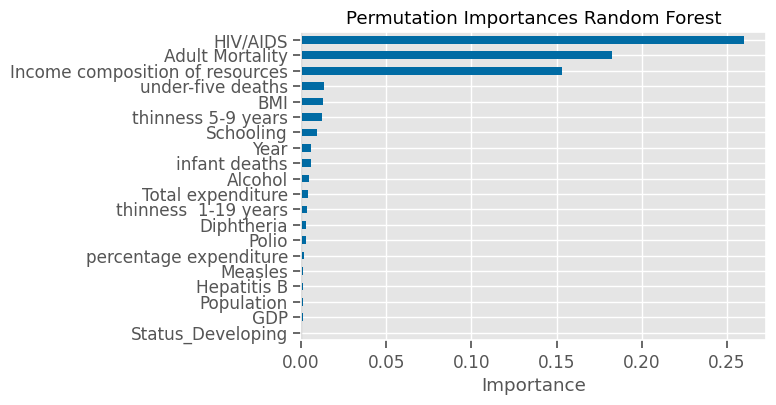

<Axes: title={'center': 'Permutation Importances Random Forest'}, xlabel='Importance'>

In [70]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(rf_importances, title='Permutation Importances Random Forest')

> Permutation Importance Can Be Applied to ANY Model!

# 🕹️Global Model Explanations

##  Applying Shap

In [71]:
# Import and init shap
import shap
shap.initjs()


### Gather a small random sample to speed the process

In [74]:
# Take a sample of the training data (nsamples=500, use random_state=SEED)
X_shap = shap.sample(X_train_df, nsamples=500, random_state=SEED)
y_shap = y_train.loc[X_shap.index]

## <center> SHAP Model Usage

![shap usage by model](Data/SHAPcheatsheet.png)

### Create SHAP explainers for LinearRegression and RandomForestRegressor

In [75]:
# Instantiate a Model Explainer with the model
rf_explainer = shap.Explainer(rf_reg)
## Get shap values from the explainer

rf_shap_value = rf_explainer(X_shap)

In [77]:
X_shap.shape

(500, 20)

In [76]:
rf_shap_values.shape

(500, 20)

In [79]:
## Create an explainer for the lin_reg
linreg_explainer = shap.Explainer(lin_reg_final, X_shap)

## get shap values for linreg
linreg_shap_values = linreg_explainer(X_shap)
linreg_shap_values.shape

(500, 20)

### Summary Bar Plots

The `show=False` flag will allow us to manipulate the figure using matplotlib.

Text(0.5, 1.0, 'Random Forest Shap Summary')

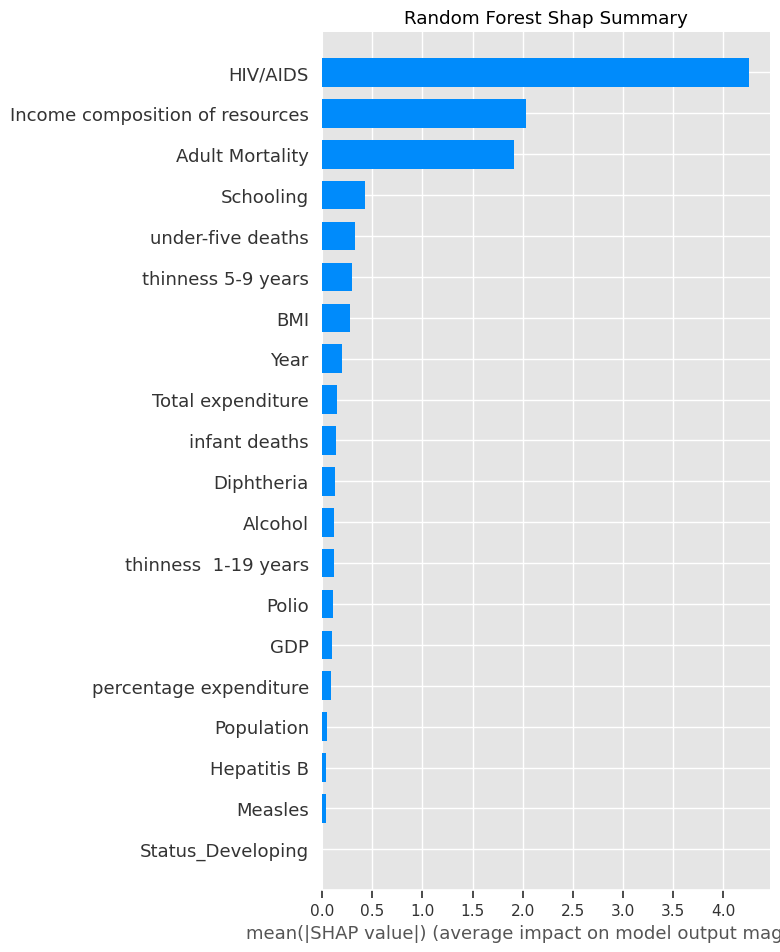

In [83]:
## create a summary plot (bar version)
shap.summary_plot(rf_shap_value, features=X_shap, plot_type='bar',
                 show=False)
plt.title('Random Forest Shap Summary')

Text(0.5, 1.0, 'Linear Regression Shap Summary')

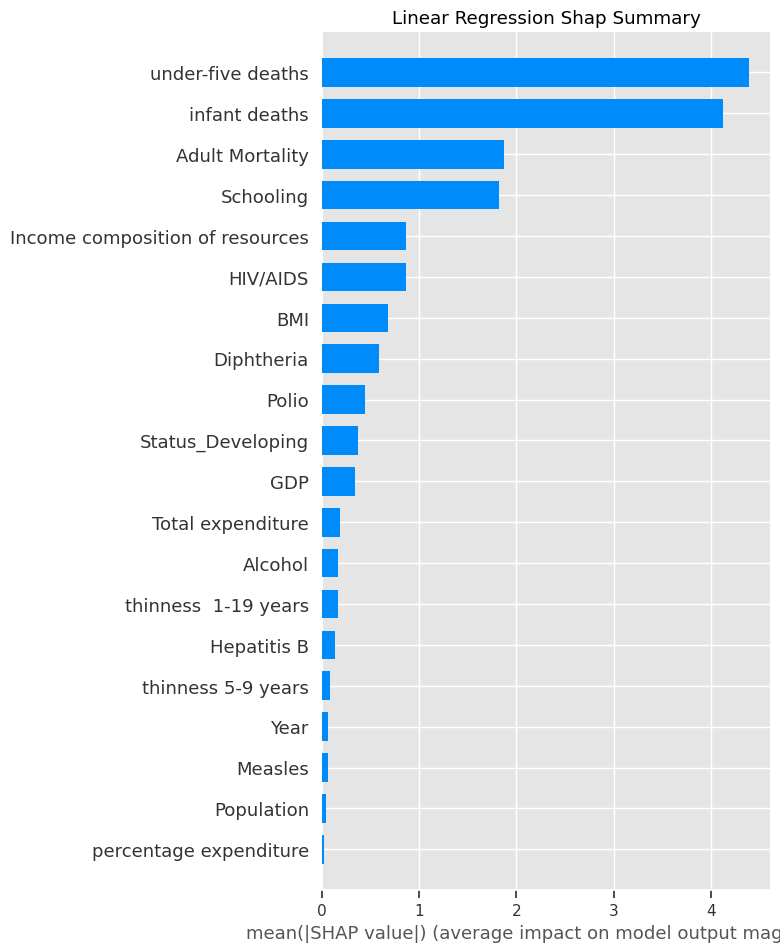

In [84]:
## create a summary plot (bar version)

shap.summary_plot(linreg_shap_values, features=X_shap, plot_type='bar',
                 show=False)
plt.title('Linear Regression Shap Summary')

Text(0.5, 1.0, 'Random Forest Shap Summary')

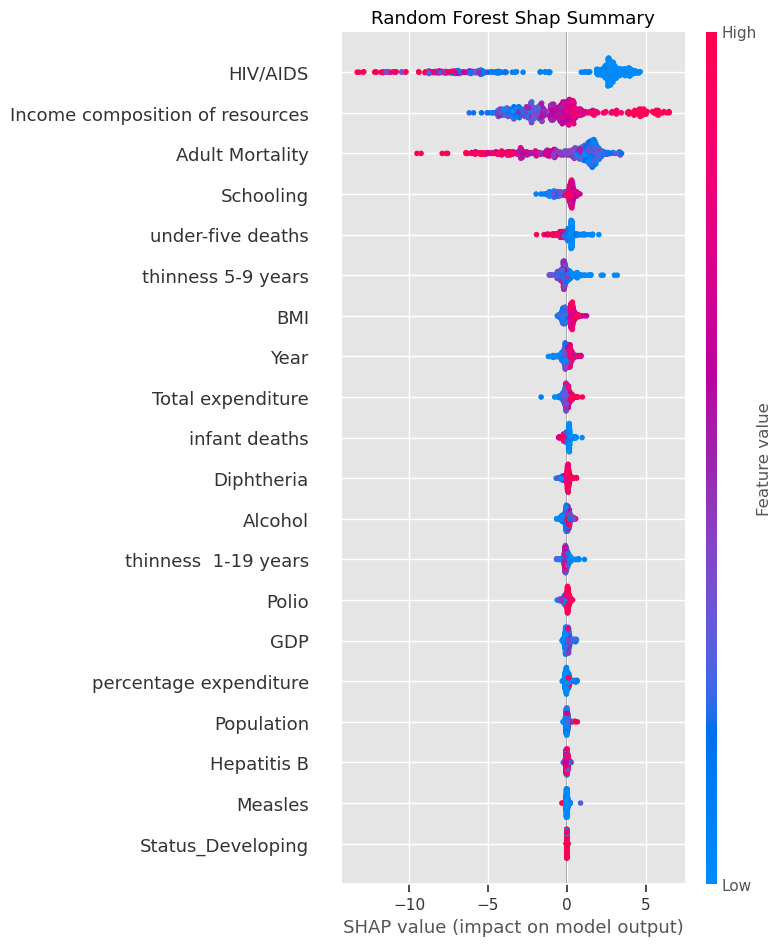

In [86]:
## create a summary plot (bar version)

shap.summary_plot(rf_shap_value, features=X_shap,
                 show=False)
plt.title('Random Forest Shap Summary')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'Linear Regression Shap Summary')

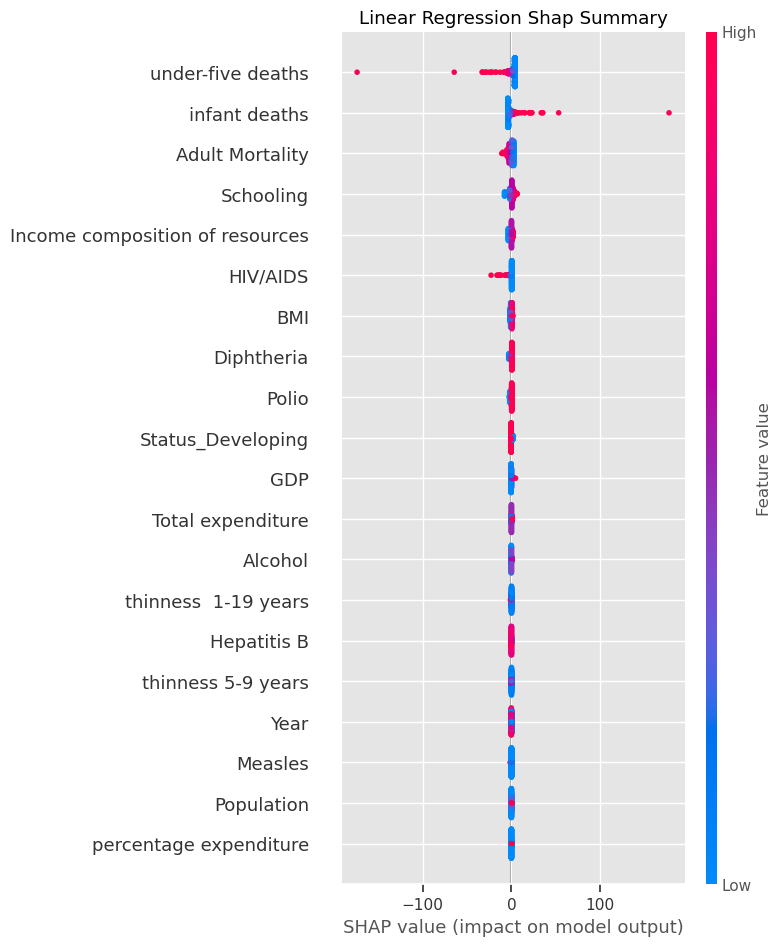

In [88]:
## create a summary plot (dot/default version)
## create a summary plot (bar version)
shap.summary_plot(linreg_shap_values, features=X_shap,
                 show=False)
plt.title('Linear Regression Shap Summary')


> So why is our LinReg predicting a high life expectancy when infant deaths are high?

## Local Explanations

In [89]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)

X_shap_local


,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
0,2011.0,418.0,26.0,3.780000,54.665917,89.000000,1865.0,22.2,38.0,88.0,11.980000,89.0,1.3,445.525000,6.611692e+06,8.1,8.0,0.392000,8.900000,1.0
1,2001.0,54.0,17.0,1.520000,33.653157,81.438929,2837.0,16.8,25.0,4.0,3.950000,4.0,13.9,243.158649,3.832230e+05,1.4,1.4,0.314000,5.300000,1.0
2,2010.0,363.0,30.0,2.470000,184.364910,83.000000,15754.0,2.7,45.0,8.0,4.410000,83.0,6.8,1463.213573,1.385330e+05,6.7,6.5,0.533000,11.800000,1.0
3,2015.0,152.0,2.0,4.580078,0.000000,76.000000,43.0,17.4,2.0,75.0,5.931982,76.0,0.1,1161.769350,1.249770e+05,1.9,11.1,0.603000,12.500000,1.0
4,2013.0,412.0,59.0,3.150000,0.000000,8.000000,48.0,26.8,81.0,79.0,5.810000,8.0,2.4,7619.088770,1.106721e+07,5.8,5.7,0.628299,11.973712,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2008.0,339.0,64.0,1.710000,60.515351,88.000000,1282.0,17.9,95.0,88.0,3.900000,88.0,6.4,916.899251,3.914842e+07,8.3,8.2,0.506000,10.400000,1.0
496,2008.0,19.0,13.0,2.210000,472.223499,95.000000,0.0,45.9,15.0,96.0,6.650000,95.0,0.4,2794.221890,1.463660e+05,1.3,1.3,0.589000,10.400000,1.0
497,2004.0,652.0,2.0,4.900000,469.582390,91.000000,1.0,32.2,4.0,96.0,5.560000,96.0,28.4,4896.583835,1.829330e+05,1.5,1.4,0.580000,11.800000,1.0
498,2010.0,12.0,3.0,1.280000,64.856167,98.000000,1.0,56.5,3.0,98.0,6.540000,98.0,0.1,414.151770,1.639931e+06,6.3,6.3,0.710000,14.400000,1.0


In [90]:
y_shap_local

0      48.9
1      45.6
2      58.0
3      68.3
4      52.3
       ... 
495    57.9
496    79.0
497    48.1
498    74.8
499    67.3
Name: Life expectancy, Length: 500, dtype: float64

In [91]:
high_life = y_shap_local.idxmax()
high_life

29

In [92]:
X_shap_local.loc[high_life]


Year                               2.009000e+03
Adult Mortality                    6.700000e+01
infant deaths                      0.000000e+00
Alcohol                            6.680000e+00
percentage expenditure             1.423749e+02
Hepatitis B                        8.143893e+01
Measles                            2.000000e+00
BMI                                5.850000e+01
under-five deaths                  0.000000e+00
Polio                              9.400000e+01
Total expenditure                  9.490000e+00
Diphtheria                         9.400000e+01
HIV/AIDS                           1.000000e-01
GDP                                8.177768e+02
Population                         4.828726e+06
thinness  1-19 years               7.000000e-01
thinness 5-9 years                 7.000000e-01
Income composition of resources    9.360000e-01
Schooling                          1.740000e+01
Status_Developing                  0.000000e+00
Name: 29, dtype: float64

### Finding a Meaningful  Example to Explain

- Let's find the example with the most infant deaths.

In [ ]:
# what is the max/range of infant deaths


In [ ]:
## saving the index of the most deaths



In [ ]:
# checking the feature values for selected example



In [ ]:
## what was the actual life expectancy?



## Shap Force Plots

### Force Plot - Linear Reg explanation

In [95]:



## plotting example force plot for most inf.deaths (from linreg)
shap.force_plot(rf_explainer.expected_value,
               shap_values=rf_shap_value[high_life].values,
               features=X_shap_local.iloc[high_life])



In [96]:
X_shap_local.describe()

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2007.704000,174.312000,24.556000,4.371967,625.719065,81.074763,1330.114000,37.737635,34.664000,79.613927,5.976018,81.825615,1.646400,7116.600364,1.006698e+07,4.856008,4.840151,0.619960,11.722023,0.852000
std,4.594628,125.657496,89.845463,3.665880,1751.196250,21.940068,4646.312819,19.496957,120.555507,26.308075,2.301289,23.272138,4.605591,12939.597865,2.189138e+07,4.136596,4.137329,0.197445,3.386950,0.355456
min,2000.000000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,2.400000,0.000000,3.000000,0.760000,3.000000,0.100000,11.553196,3.600000e+01,0.100000,0.100000,0.000000,0.000000,0.000000
25%,2004.000000,78.000000,0.000000,1.272500,3.067673,81.438929,0.000000,19.775000,1.000000,75.000000,4.455000,78.000000,0.100000,555.273667,2.911110e+05,1.600000,1.600000,0.496500,9.775000,1.000000
50%,2008.000000,152.000000,3.500000,3.970000,63.252108,86.000000,20.000000,41.850000,4.000000,92.000000,5.931982,91.000000,0.100000,2489.955836,3.677234e+06,3.600000,3.600000,0.636500,11.973712,1.000000
75%,2012.000000,253.500000,22.000000,6.742500,341.383924,96.000000,355.250000,55.200000,26.250000,97.000000,7.232500,97.000000,0.900000,7619.088770,1.106721e+07,7.300000,7.300000,0.759250,13.900000,1.000000
max,2015.000000,717.000000,1700.000000,16.990000,15515.752340,99.000000,47147.000000,77.100000,2200.000000,99.000000,15.570000,99.000000,48.800000,113751.850000,2.551311e+08,27.300000,28.300000,0.938000,20.700000,1.000000


### Force Plot - RandomForest explanation

In [ ]:
## plotting example force plot for most inf.deaths (from rf)





> ***Q: What do you notice when comparing the lin reg and rf reg force plots?***

# LIME

In [98]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
## Don't need to show it the model yet.
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      feature_names = X_shap_local.columns,
                                      mode='regression')


In [100]:
## Use the lime explainer to explain the selected example used above 

exp = lime_explainer.explain_instance(X_shap_local.loc[high_life],
                                      rf_reg.predict)
exp.show_in_notebook()


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


___
# APPENDIX

### Global Force Plots

In [101]:
shap.force_plot(linreg_explainer.expected_value,linreg_shap_values.values,X_shap_local,)

In [102]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values.values,X_shap_local)

Try changing the X and Y axis features